# Time Series Forecasting with Python Dart

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from darts import TimeSeries
from typing import Optional, Callable
from darts import models, metrics, backtesting
from darts.preprocessing import ScalerWrapper
from darts.utils import missing_values
from custom_code import sumape, create_fortnights
%matplotlib inline

In [3]:
pd.plotting.register_matplotlib_converters()


# Dart

In [4]:
df = pd.read_csv("efecty_drawdowns.csv", dtype={"y":float, "entity_id":int, "ds":str}, index_col=0)
df["ds"] = pd.to_datetime(df["ds"], format='%Y-%m-%d')
df.head()

,ds,y,entity_id
0,2019-02-05,3383730.0,995152
1,2019-02-05,988994.0,992133
2,2019-02-05,597150.0,995388
3,2019-02-05,50000.0,902343
4,2019-02-05,1426410.0,993733


In [5]:
df_992133 = df[df.entity_id == 992133]
df_992133["y"].isna().sum() 

0

In [6]:
df_992133.loc[df_992133["ds"] =="2020-01-01"]

,ds,y,entity_id


In [7]:
df_992133

,ds,y,entity_id
1,2019-02-05,988994.0,992133
278,2019-02-06,1238432.0,992133
526,2019-02-07,600000.0,992133
691,2019-02-08,1348550.0,992133
804,2019-02-09,1567525.0,992133
...,...,...,...
72078,2020-02-25,2350000.0,992133
72308,2020-02-26,1068926.0,992133
72529,2020-02-27,748462.0,992133
72841,2020-02-28,3107942.0,992133


## Plot one entity

<AxesSubplot:xlabel='ds'>

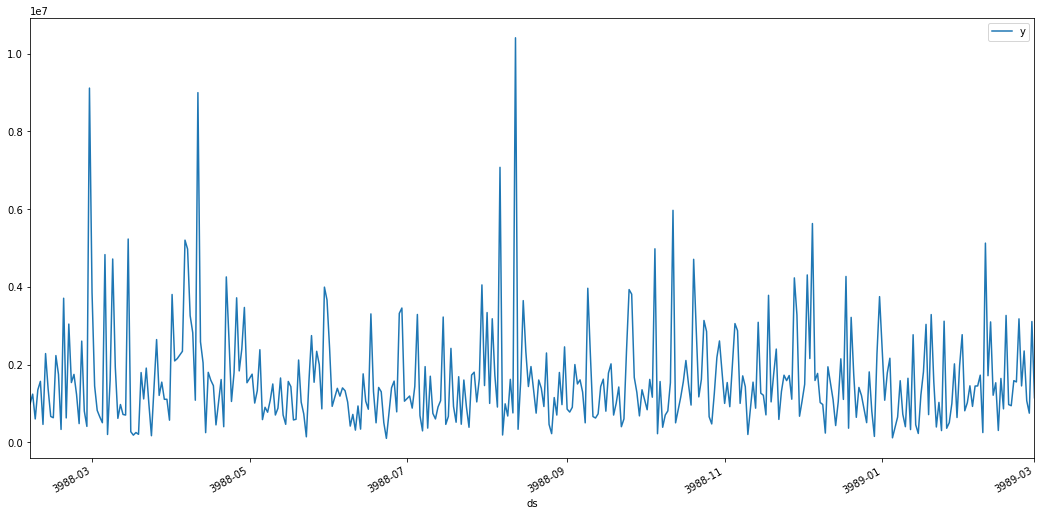

In [8]:
df_992133.plot(x="ds", y="y", figsize=(18,9))

In [9]:
df_992133.iloc[300]

ds           2019-12-15 00:00:00
y                     1.0447e+06
entity_id                 992133
Name: 56674, dtype: object

## Fill missing values
TimeSeries add missing date with nan values, and you have to fillna values with `auto_fillna` function

In [10]:
date_division = "20191215"
series = TimeSeries.from_dataframe(df_992133, "ds", "y" )
series = missing_values.auto_fillna(series, method="slinear")
train, val = series.split_after(pd.Timestamp(date_division))
len(train) + len(val)

390

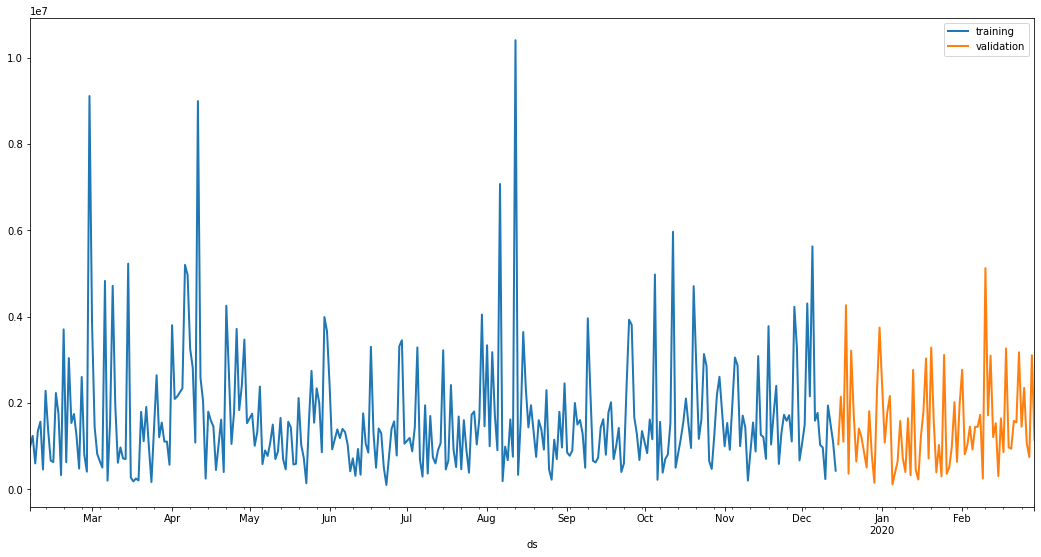

In [11]:
train, val = series.split_before(pd.Timestamp(date_division))
train.plot(lw=2, label='training', figsize=(18,9))
val.plot(lw=2, label='validation', figsize=(18,9))
plt.legend();

## Prophet

In [12]:
model = models.Prophet()
model.fit(train)
prediction = model.predict(len(val))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 0, 'Year')

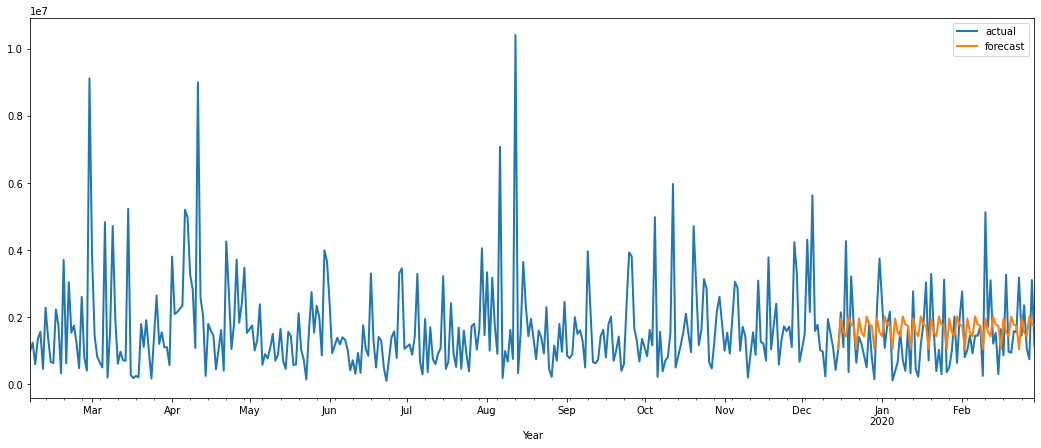

In [13]:
series.plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")

### Add holidays

In [14]:
fortnights = create_fortnights(series.pd_dataframe().index[0].date(), series.pd_dataframe().index[-1].date())

In [15]:
fortnights.tail()

,holiday,ds
21,quincena,2019-12-30
22,quincena,2020-01-15
23,quincena,2020-01-30
24,quincena,2020-02-14
25,quincena,2020-02-28


In [16]:
model = models.Prophet(holidays=fortnights, interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)
train.add_holidays(country_code="COL")
model.fit(train)
prediction_prophet = model.predict(len(val))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Text(0.5, 0, 'Year')

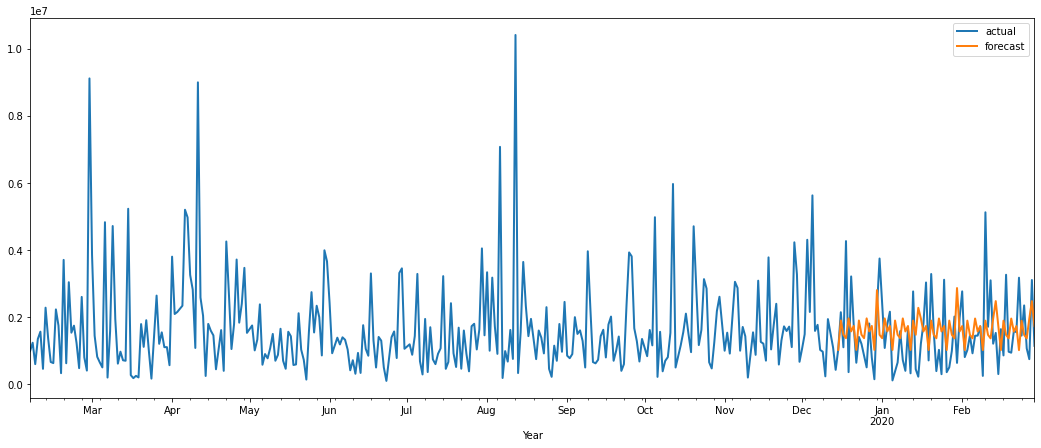

In [17]:
series.plot(label="actual", lw=2, figsize=(18,7))
prediction_prophet.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")

In [18]:
print('The SuMAPE for Prophet is: {:.2f}.'.format(sumape(val, prediction_prophet)))

The SuMAPE for Prophet is: 28.53.


## Theta
The model Theta contains an implementation of Assimakopoulos and Nikolopoulos' Theta method. This method has known great success, particularly in the M3-competition.
[Link](https://robjhyndman.com/papers/Theta.pdf)


In [19]:
# Search for the best theta parameter, by trying 50 different values
thetas = np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = models.Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = sumape(val, pred_theta)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta
best_theta

[2020-07-21 15:41:49,296] INFO | darts.models.theta | Theta model inferred seasonality of training series: 3
INFO:darts.models.theta:Theta model inferred seasonality of training series: 3
[2020-07-21 15:41:49,414] INFO | darts.models.theta | Theta model inferred seasonality of training series: 3
INFO:darts.models.theta:Theta model inferred seasonality of training series: 3
[2020-07-21 15:41:49,501] INFO | darts.models.theta | Theta model inferred seasonality of training series: 3
INFO:darts.models.theta:Theta model inferred seasonality of training series: 3
[2020-07-21 15:41:49,587] INFO | darts.models.theta | Theta model inferred seasonality of training series: 3
INFO:darts.models.theta:Theta model inferred seasonality of training series: 3
[2020-07-21 15:41:49,735] INFO | darts.models.theta | Theta model inferred seasonality of training series: 3
INFO:darts.models.theta:Theta model inferred seasonality of training series: 3
[2020-07-21 15:41:49,818] INFO | darts.models.theta | Theta 

2.2448979591836746

In [20]:
best_theta_model = models.Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The SuMAPE is: {:.2f}, with theta = {}.'.format(sumape(val, pred_best_theta), best_theta))

[2020-07-21 15:41:53,868] INFO | darts.models.theta | Theta model inferred seasonality of training series: 3
INFO:darts.models.theta:Theta model inferred seasonality of training series: 3
The SuMAPE is: 28.88, with theta = 2.2448979591836746.


Text(0.5, 0, 'Year')

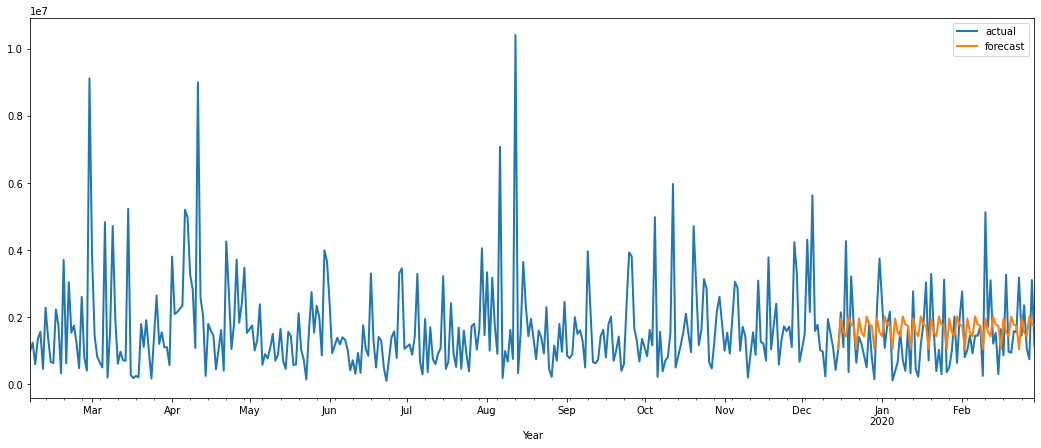

In [21]:
series.plot(label="actual", lw=2, figsize=(18,7))
prediction.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")

### Ensembling several predictions
For instance, in our example of a "less naive" model above, we manually combined a naive seasonal model with a naive drift model. Here, we will try to find such combinations in an automated way, using RegressionModels. A regression model is a model that predicts a target time series from a bunch of features time series. If the features time series are themselves obtained from forecasting models, their future (predicted) values can be combined using the regression model to obtain a final forecast.


Here, we will first compute the historical predictions two naive seasonal models (with 7 and 14 days seasonality), and naive drift model. To compute the historical predictions, we can simply reuse the backtest_forecasting() method:

In [22]:
models_naive = [models.NaiveSeasonal(7), models.NaiveSeasonal(14), models.NaiveDrift()]

model_predictions = [backtesting.backtest_forecasting(series, m, pd.Timestamp(date_division), fcast_horizon_n=14, verbose=True) for m in models_naive]

In [24]:
""" We build the regression model, and tell it to use the 14 preceding points to fit the regression
"""
regr_model = models.StandardRegressionModel(train_n_points=14)

""" Our target series is what we want to predict (the actual data)
    It has to have the same time index as the features series:
"""
series_target = series.slice_intersect(model_predictions[0])

""" Here we backtest our regression model
"""
regr_date_division = '20200101'	
ensemble_pred = backtesting.backtest_regression(model_predictions, series_target, regr_model, 
                                    pd.Timestamp(regr_date_division), fcast_horizon_n=3, verbose=True)



MAPE Error ensemble: 27.51%


Text(0.5, 0, 'Year')

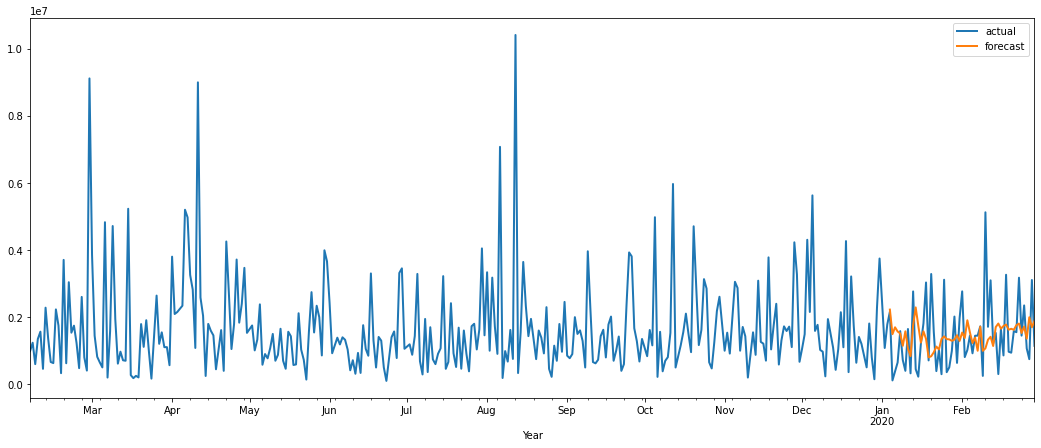

In [25]:
print('SuMAPE Error ensemble: {:.2f}%'.format(sumape(series, ensemble_pred)))
series.plot(label="actual", lw=2, figsize=(18,7))
ensemble_pred.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")

### Try explore models function

In [14]:
date_division_val = "20191014"
date_division_test = "20191228"
series = TimeSeries.from_dataframe(df_992133, "ds", "y" )
series = missing_values.auto_fillna(series, method="slinear")
train, val_test = series.split_after(pd.Timestamp(date_division_val))
val, test = val_test.split_after(pd.Timestamp(date_division_test))
len(train) , len(val), len(test) 

(252, 75, 63)

ib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/fabian/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
[2020-07-20 15:53:45,384] INFO | darts.backtesting.backtesting | Chosen parameters: {'trend': 'multiplicative', 'seasonal': 'multiplicative', 'seasonal_periods': 7}
INFO:darts.backtesting.backtesting:Chosen parameters: {'trend': 'multiplicative', 'seasonal': 'multiplicative', 'seasonal_periods': 7}
[2020-07-20 15:53:47,229] INFO | darts.backtesting.backtesting | Chosen parameters: {'K': 27}
INFO:darts.backtesting.backtesting:Chosen parameters: {'K': 27}
[2020-07-20 15:53:48,994] INFO | darts.backtesting.backtesting | Chosen parameters: {'nr_freqs_to_keep': 2, 'trend': None}
INFO:darts.backtesting.backtesting:Chosen parameters: {'nr_freqs_to_keep': 2, 'tr

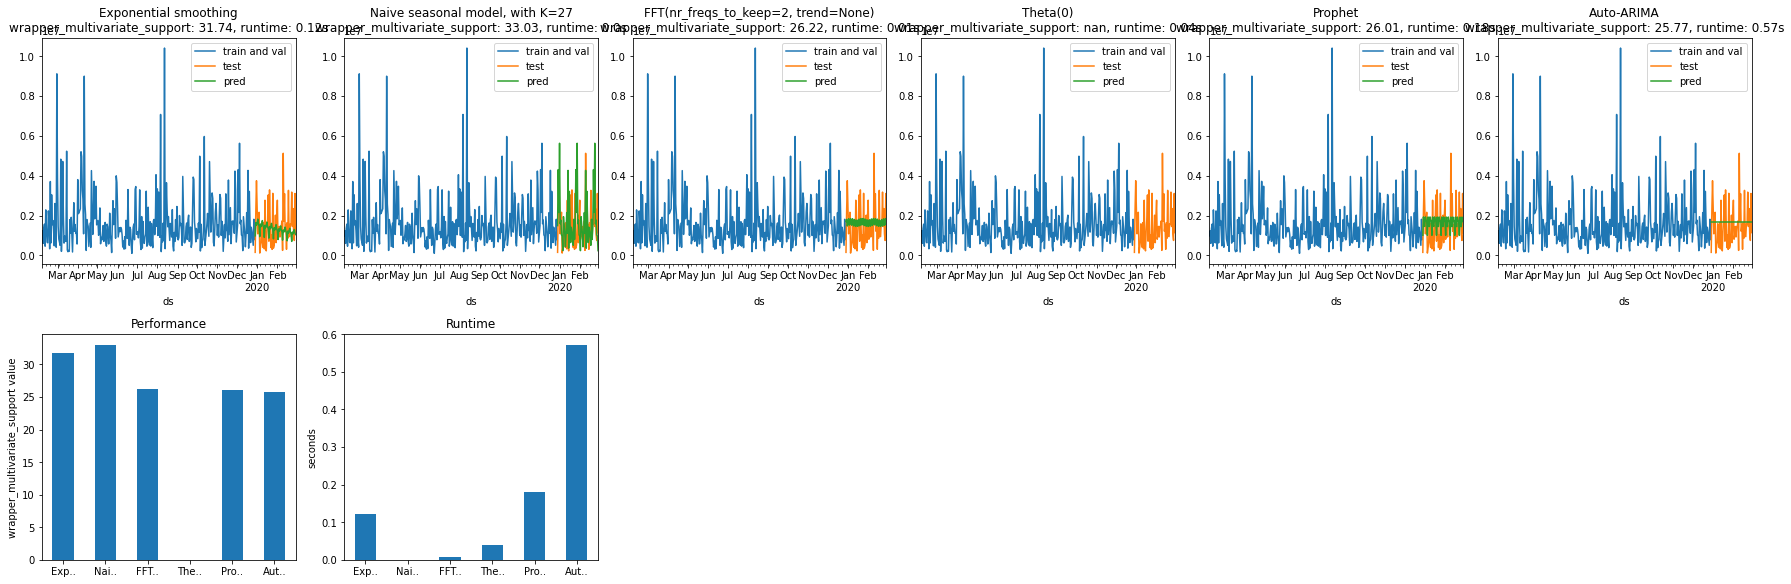

In [27]:
backtesting.backtesting.explore_models(train, val, test, metric=sumape, verbose=False, plot_width=7)

## Use other entity

<AxesSubplot:xlabel='ds'>

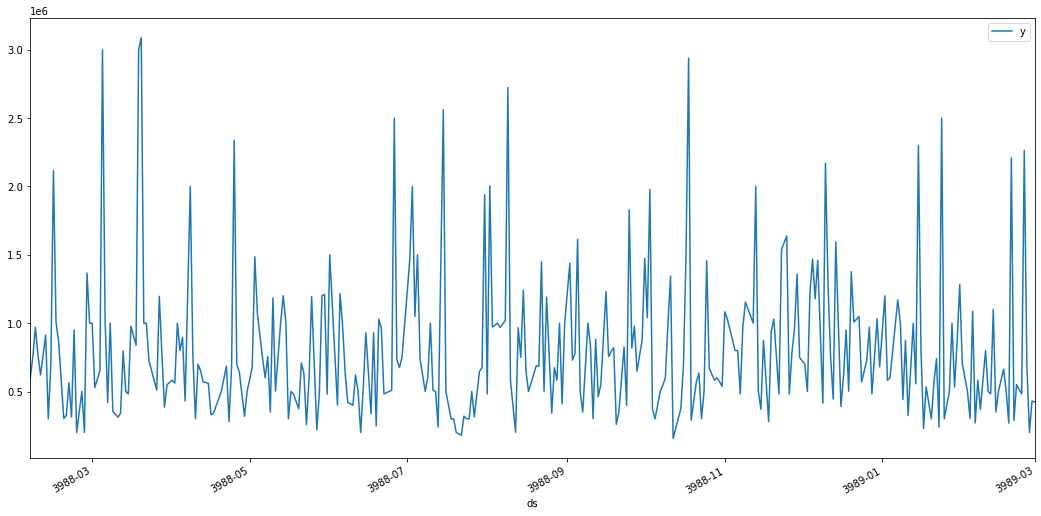

In [11]:
df_995388 = df[df.entity_id == 995388]
df_995388.plot(x="ds", y="y", figsize=(18,9))

In [13]:
date_division = "20191215"
series = TimeSeries.from_dataframe(df_995388, "ds", "y" )
series = missing_values.auto_fillna(series, method="slinear")
train, val = series.split_after(pd.Timestamp(date_division))
len(train) + len(val)

390

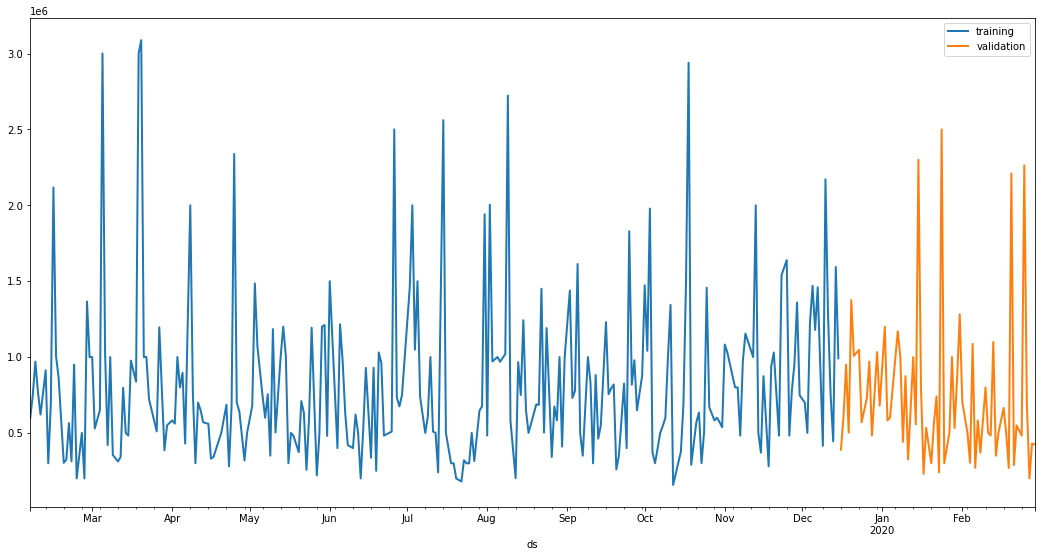

In [14]:
train.plot(lw=2, label='training', figsize=(18,9))
val.plot(lw=2, label='validation', figsize=(18,9))
plt.legend();

In [18]:
model = models.Prophet(holidays=fortnights, interval_width=0.95, weekly_seasonality=True)
train.add_holidays(country_code="COL")
model.fit(train)
prediction_prophet = model.predict(len(val))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 0, 'Year')

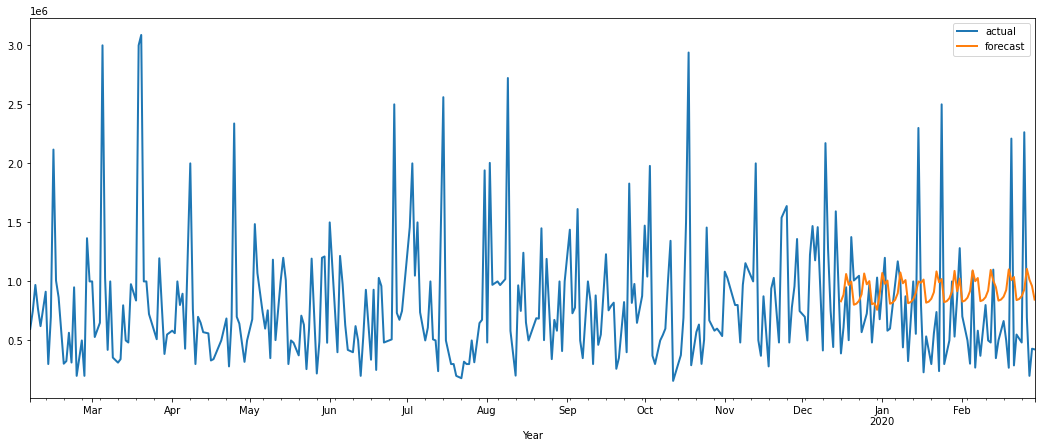

In [19]:
series.plot(label="actual", lw=2, figsize=(18,7))
prediction_prophet.plot(label="forecast", lw=2, figsize=(18,7))
plt.legend()
plt.xlabel("Year")

In [23]:
print('MAPE Error ensemble: {:.2f}%'.format(sumape(series, prediction_prophet)))

MAPE Error ensemble: 26.54%
